# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [15]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import statistics
import math
import time
import itertools
import colorsys
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
from matplotlib.patches import Patch
import os

# Options

In [16]:
post_normalized_data = True

if post_normalized_data:
    pn_file = 'postNorm'
else:
    pn_file = 'noNorm'

In [17]:
#Initial Trial Data is Stored on 17Jan23
d1_pat_id = 'BLSA_1742_04_MCIAD_m41'
d1_pat_tag = d1_pat_id[-3:]
d1_slice_num = 5
d1_target_SNR = 100
d1_data_date_oi = '25Apr24'
d1_process_date_oi = '25Apr24'

d1_data_folder = f"{d1_pat_tag}_slice{d1_slice_num}_SNR_{d1_target_SNR}_BIC_filter_{d1_data_date_oi}"
d1_analysis_file = f"{pn_file}_{d1_process_date_oi}"

In [18]:
#Initial Trial Data is Stored on 17Jan23
d2_pat_id = 'BLSA_1742_04_MCIAD_m41'
d2_pat_tag = d2_pat_id[-3:]
d2_slice_num = 5
d2_target_SNR = 75
d2_data_date_oi = '25Apr24'
d2_process_date_oi = '25Apr24'

d2_data_folder = f"{d2_pat_tag}_slice{d2_slice_num}_SNR_{d2_target_SNR}_BIC_filter_{d2_data_date_oi}"
d2_analysis_file = f"{pn_file}_{d2_process_date_oi}"

In [19]:
#Initial Trial Data is Stored on 17Jan23
d3_pat_id = 'BLSA_1935_06_MCIAD_m79'
d3_pat_tag = d3_pat_id[-3:]
d3_slice_num = 5
d3_target_SNR = 75
d3_data_date_oi = '25Apr24'
d3_process_date_oi = '26Apr24'

d3_data_folder = f"{d3_pat_tag}_slice{d3_slice_num}_SNR_{d3_target_SNR}_BIC_filter_{d3_data_date_oi}"
d3_analysis_file = f"{pn_file}_{d3_process_date_oi}"

# Signal Functions

In [20]:
def G_biX_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return signal

def G_moX_off(t, con, tau, offSet): 
    signal = con*np.exp(-t/tau) + offSet
    return signal

# Define Parameters

In [21]:
def load_results(pat_id, data_folder, analysis_file): 
    file_path = f'Intermediate_ExpResults/{pat_id}/{data_folder}/{analysis_file}.pkl'

    if os.path.isfile(file_path):
        with open(file_path, 'rb') as handle:
            dict = pickle.load(handle)
            data_hyperParam = dict['HyperParams_exp']
            gs_BIC_choices = dict['gs_BIC_region']
            gs_nonreg_estimates = dict['gs_nonreg_est']
            exp_BIC_region = dict['exp_BIC_region']
            nonreg_estimates = dict['exp_nonreg_est']
            GCV_estimates = dict['exp_GCV_est']

            handle.close()

    else:
        raise ValueError(f'There is not a valid results files to load. Check path:{file_path}')

    file_path = data_hyperParam

    if os.path.isfile(file_path):
        with open(file_path, 'rb') as handle:
            dict = pickle.load(handle)
            mask_shape = dict['mask_shape']
            SNR_folder = dict['SNR_info_folder']
            slice_num = dict["data_slice"]
    else:
        raise ValueError(f'Underlying file missing. Check path:{file_path}')
    
    file_path = SNR_folder

    if os.path.isfile(file_path):
        with open(file_path, 'rb') as handle:
            dict = pickle.load(handle)
            sigma_SNR = dict['SNR']
            handle.close()
        
    else:
        raise ValueError(f'Underlying file missing. Check path:{file_path}')

    print(f'Data loaded in for slice {slice_num} of {pat_id[-3:]}')
    print(f'SNR of original brain sigma slice = {sigma_SNR:.2f}')
    
    p_est_mat = [gs_nonreg_estimates, nonreg_estimates, GCV_estimates]
    strux_mat = [mask_shape, exp_BIC_region, gs_BIC_choices]
    
    return p_est_mat, strux_mat, sigma_SNR

In [22]:
d1_p_est_mat, d1_strux_mat, d1_SNR = load_results(d1_pat_id, d1_data_folder, d1_analysis_file)
d2_p_est_mat, d2_strux_mat, d2_SNR = load_results(d2_pat_id, d2_data_folder, d2_analysis_file)
d3_p_est_mat, d3_strux_mat, d3_SNR = load_results(d3_pat_id, d3_data_folder, d3_analysis_file)

###################### Parameters Loop Through

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

Data loaded in for slice 5 of m41
SNR of original brain sigma slice = 159.09
Data loaded in for slice 5 of m41
SNR of original brain sigma slice = 159.09
Data loaded in for slice 5 of m79
SNR of original brain sigma slice = 102.19


# Define General Functions

### Small Helper Functions

In [23]:
def calc_improvement(old, new):
    return (old - new)/old

def get_brain_outline(raw):
    n_vert = raw.shape[0]
    n_hori = raw.shape[1]
    I_outline = np.zeros((n_vert, n_hori))
    for i_vert in range(n_vert):
        for i_hori in range(n_hori):
            try:
                init_sig = raw[i_vert, i_hori]
                if i_vert > 0:
                    init_sig_up = raw[i_vert-1, i_hori]
                else:
                    init_sig_up = 0
                if i_vert < n_vert - 1:
                    init_sig_dn = raw[i_vert+1, i_hori]
                else:
                    init_sig_dn = 0
                if i_hori > 0:
                    init_sig_lt = raw[i_vert, i_hori - 1]
                else:
                    init_sig_lt = 0
                if i_hori < n_hori - 1:
                    init_sig_rt = raw[i_vert, i_hori + 1]
                else:
                    init_sig_up = 0
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = np.nan
    return I_outline

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

# Images

In [24]:
brain_outline = get_brain_outline(d1_strux_mat[0])
d1_outline_indices = np.where(brain_outline == 1)

brain_outline = get_brain_outline(d2_strux_mat[0])
d2_outline_indices = np.where(brain_outline == 1)

brain_outline = get_brain_outline(d3_strux_mat[0])
d3_outline_indices = np.where(brain_outline == 1)

### BIC Regions

/home/hamptong2/anaconda3/envs/BrainReg/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/hamptong2/anaconda3/envs/BrainReg/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


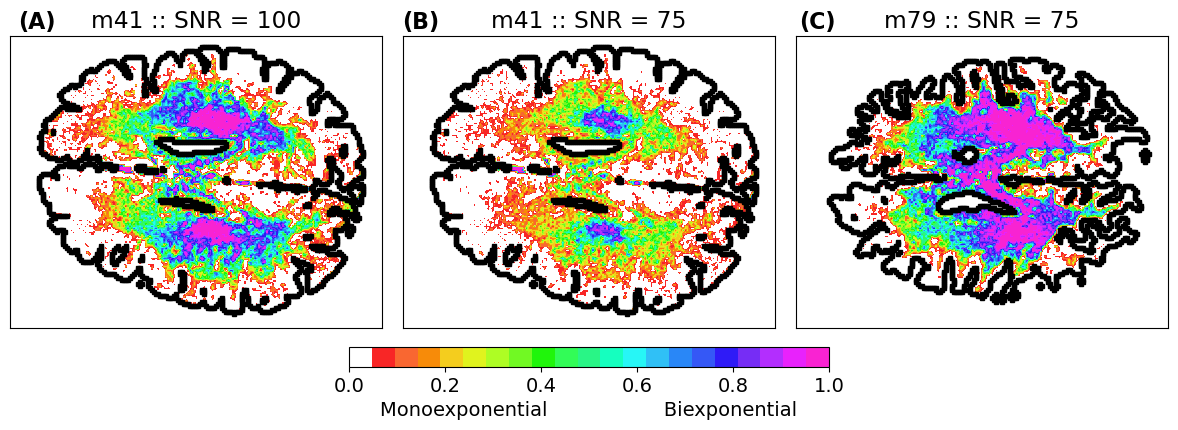

In [25]:
gen_colors = [(1,1,1)] + _get_colors(d1_p_est_mat[1].shape[0]+2)
BiX_freq_cmap = colors.ListedColormap(gen_colors[:-2])

fig, ax = plt.subplots(1,3, figsize=(12,5),tight_layout=True)

# plt.rc('font', size = 18)
# fig.suptitle('Frequency of Voxels Labeled as Biexponential by BIC\nAcross Noise Realizations', y=0.95)

plt.rc('font', size = 14)

BIC = ax[0].imshow(np.sum(d1_strux_mat[1], axis = 0)/d1_strux_mat[1].shape[0], cmap = BiX_freq_cmap, vmin = 0, vmax = 1)
ax[0].plot(d1_outline_indices[1], d1_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[0].set_title(f'{d1_pat_tag} :: SNR = {d1_target_SNR}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

BIC = ax[1].imshow(np.sum(d2_strux_mat[1], axis = 0)/d2_strux_mat[1].shape[0], cmap = BiX_freq_cmap, vmin = 0, vmax = 1)
ax[1].plot(d2_outline_indices[1], d2_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[1].set_title(f'{d1_pat_tag} :: SNR = {d2_target_SNR}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

BIC = ax[2].imshow(np.sum(d3_strux_mat[1], axis = 0)/d3_strux_mat[1].shape[0], cmap = BiX_freq_cmap, vmin = 0, vmax = 1)
ax[2].plot(d3_outline_indices[1], d3_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[2].set_title(f'{d3_pat_tag} :: SNR = {d3_target_SNR}')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

cb_ax = fig.add_axes([0.30,0.13,0.4,.04])
fig.colorbar(BIC, orientation = 'horizontal', cax=cb_ax, label = 'Monoexponential                   Biexponential')

plt.rc('font', size = 16)
fig.text(0.04,0.82, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.36,0.82, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.69,0.82, '(C)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

### MWF Comparison Graphs

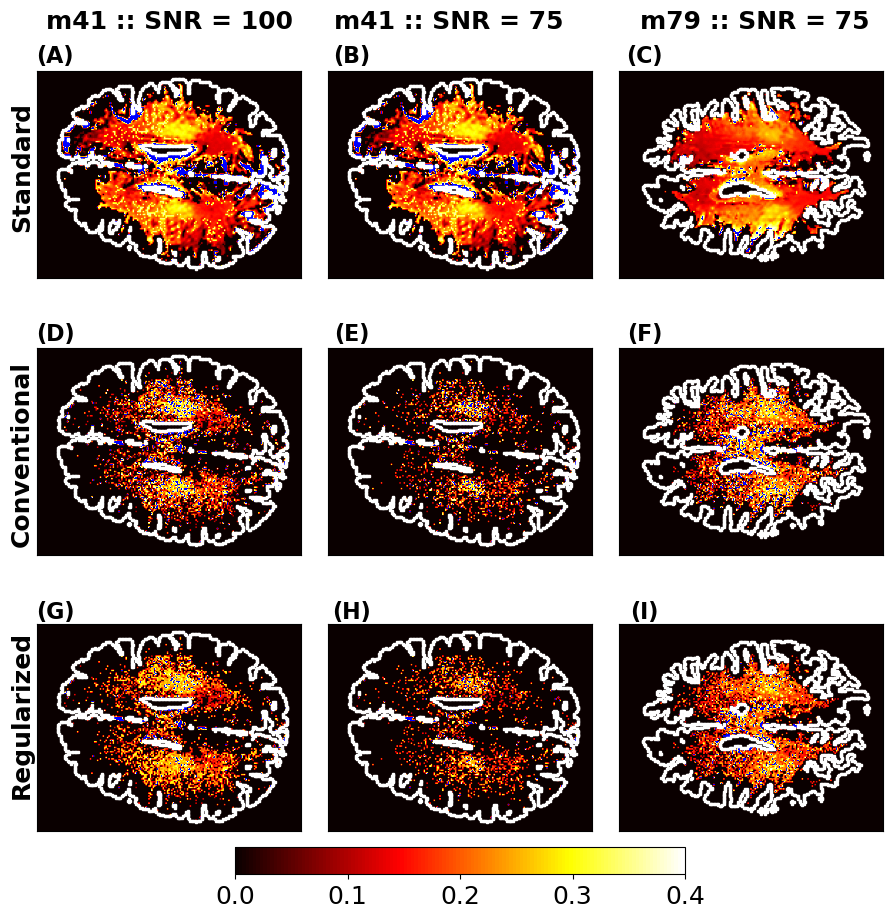

In [26]:
fig, ax = plt.subplots(3,3,figsize=(9,9),tight_layout=True)
plt.rc('font', size  = 16)

iter_oi = 0

MWF_cb_map = plt.get_cmap('hot', 128)
# stack_white = np.vstack(((1,0,0,0),MWF_cb_map(np.linspace(0,1,128))))
# MWF_cb_map = colors.ListedColormap(stack_white, name = 'MWF_cb_map')
MWF_cb_map.set_extremes(over = 'blue')
extend_opt = "max" #min, max, both, neither
upper_bound = 0.4

data_array = [d1_p_est_mat, d2_p_est_mat, d3_p_est_mat]
strux_array = [d1_strux_mat, d2_strux_mat, d3_strux_mat]
outline_array = [d1_outline_indices, d2_outline_indices, d3_outline_indices]

for iDat in range(len(data_array)):
    outline_indices = outline_array[iDat]
    data = data_array[iDat]
    BIC_region = strux_array[iDat][1][iter_oi,:,:]

    # fig.suptitle('Myelin Water Fraction (MWF) Maps' + '\nNoise Realization: '+ str(iter_oi+1) + ' :: SNR = ' + str(np.round(SNR_array[iter_oi],2)))
    imref = ax[0,iDat].imshow(data[0][:,:,0], cmap = MWF_cb_map, vmin = 0, vmax = upper_bound)
    # ax[0].set_title('Standard Reference')
    ax[0,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[0,iDat].plot(outline_indices[1],outline_indices[0], color = 'white', marker = 's', ls = '', markersize = 1.5)

    imNLLS = ax[1,iDat].imshow(data[1][iter_oi,:,:,0]*BIC_region, cmap = MWF_cb_map, vmin=0, vmax=upper_bound)
    # ax[1].set_title('Nonregularized NLLS')
    ax[1,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[1,iDat].plot(outline_indices[1],outline_indices[0], color = 'white', marker = 's', ls = '', markersize = 1.5)

    imGCV = ax[2,iDat].imshow(data[2][iter_oi,:,:,0]*BIC_region, cmap = MWF_cb_map, vmin=0, vmax=upper_bound)
    # ax[2].set_title('Regularized NLLS')
    ax[2,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[2,iDat].plot(outline_indices[1],outline_indices[0], color = 'white', marker = 's', ls = '', markersize = 1.5)

plt.rc('font', size = 16)
fig.text(0.05,0.94, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.94, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.94, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.63, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.63, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.63, '(F)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.322, '(G)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.322, '(H)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.322, '(I)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 18)
fig.text(0.04,0.97,f'{d1_pat_tag} :: SNR = {d1_target_SNR}', weight = 'bold')
fig.text(0.36,0.97,f'{d2_pat_tag} :: SNR = {d2_target_SNR}', weight = 'bold')
fig.text(0.70,0.97,f'{d3_pat_tag} :: SNR = {d3_target_SNR}', weight = 'bold')
fig.text(0, 0.75 ,f'Standard', rotation = 'vertical', weight = 'bold')
fig.text(0, 0.40 ,f'Conventional', rotation = 'vertical', weight = 'bold')
fig.text(0, 0.12 ,f'Regularized', rotation = 'vertical', weight = 'bold')

cb_ax = fig.add_axes([0.25,0.03,0.5,.03])
fig.colorbar(imGCV, orientation = 'horizontal', cax=cb_ax)

plt.show()

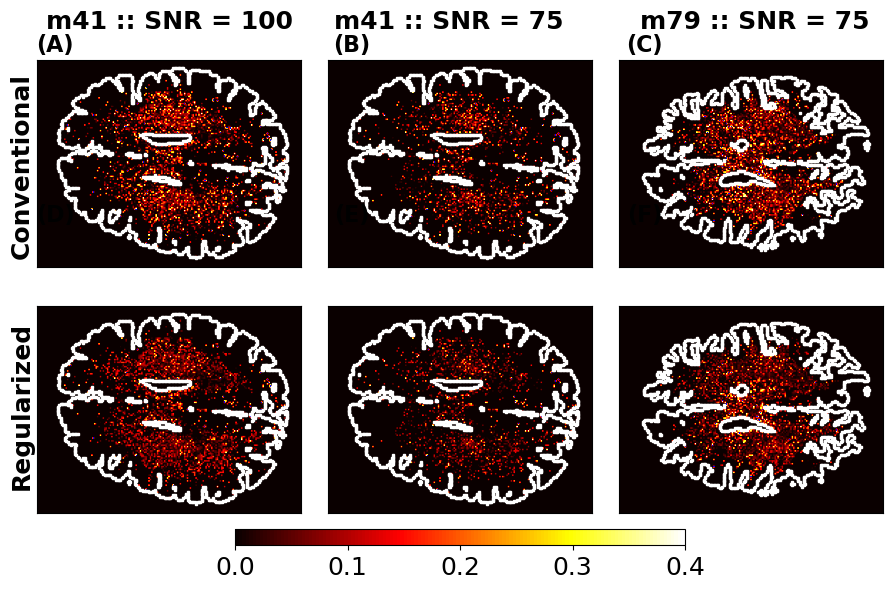

In [27]:
fig, ax = plt.subplots(2,3,figsize=(9,5.5),tight_layout=True)
plt.rc('font', size  = 16)

iter_oi = 0

MWF_cb_map = plt.get_cmap('hot', 128)
# stack_white = np.vstack(((1,0,0,0),MWF_cb_map(np.linspace(0,1,128))))
# MWF_cb_map = colors.ListedColormap(stack_white, name = 'MWF_cb_map')
MWF_cb_map.set_extremes(over = 'blue')
extend_opt = "max" #min, max, both, neither
upper_bound = 0.4

data_array = [d1_p_est_mat, d2_p_est_mat, d3_p_est_mat]
strux_array = [d1_strux_mat, d2_strux_mat, d3_strux_mat]
outline_array = [d1_outline_indices, d2_outline_indices, d3_outline_indices]

for iDat in range(len(data_array)):
    outline_indices = outline_array[iDat]
    data = data_array[iDat]
    BIC_region = strux_array[iDat][1][iter_oi,:,:]

    imNLLS = ax[0,iDat].imshow(np.abs(data[1][iter_oi,:,:,0] - data[0][:,:,0])*BIC_region, cmap = MWF_cb_map, vmin=0, vmax=upper_bound)
    # ax[0].set_title('Nonregularized NLLS')
    ax[0,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[0,iDat].plot(outline_indices[1],outline_indices[0], color = 'white', marker = 's', ls = '', markersize = 1.5)

    imGCV = ax[1,iDat].imshow(np.abs(data[2][iter_oi,:,:,0]- data[0][:,:,0])*BIC_region, cmap = MWF_cb_map, vmin=0, vmax=upper_bound)
    # ax[2].set_title('Regularized NLLS')
    ax[1,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[1,iDat].plot(outline_indices[1],outline_indices[0], color = 'white', marker = 's', ls = '', markersize = 1.5)

plt.rc('font', size = 16)
fig.text(0.05,0.94, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.94, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.94, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.63, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.63, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.63, '(F)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 18)
fig.text(0.04,0.97,f'{d1_pat_tag} :: SNR = {d1_target_SNR}', weight = 'bold')
fig.text(0.36,0.97,f'{d2_pat_tag} :: SNR = {d2_target_SNR}', weight = 'bold')
fig.text(0.70,0.97,f'{d3_pat_tag} :: SNR = {d3_target_SNR}', weight = 'bold')
fig.text(0, 0.56 ,f'Conventional', rotation = 'vertical', weight = 'bold')
fig.text(0, 0.14 ,f'Regularized', rotation = 'vertical', weight = 'bold')

cb_ax = fig.add_axes([0.25,0.03,0.5,.03])
fig.colorbar(imGCV, orientation = 'horizontal', cax=cb_ax)

plt.show()

### MSE Composistion Maps

In [30]:
delta_txt = r'$\Delta$'

##### MWF Individual Noise Realizations

In [28]:
### Individual Plot Calculations

scan_num_list = []#np.arange(0,iterations,1)

list_NR_DRMSE = []

for scan_num in scan_num_list:

    new_diff = np.abs(GCV_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])
    old_diff = np.abs(nonreg_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = 0.5#np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*exp_BIC_region[scan_num,:,:]

    num_vox = np.sum(exp_BIC_region[scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum((nonreg_estimates[scan_num,:,:,0]*exp_BIC_region[scan_num,:,:] - gs_nonreg_estimates[:,:,0]*exp_BIC_region[scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum((GCV_estimates[scan_num,:,:,0]*exp_BIC_region[scan_num,:,:] - gs_nonreg_estimates[:,:,0]*exp_BIC_region[scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new
    
    fig, ax = plt.subplots(1,1,figsize=(5.5,6.5),tight_layout=True)
    plt.rc('font', size  = 20)
    delta_txt = r'$\Delta$'
    fig.suptitle(f'Individual Scan {delta_txt}RMSE in\nScan {scan_num+1} of {iterations} at SNR = {target_SNR}' )
    plt.rc('font', size  = 16)

    pNLLS = ax.imshow(ACD_fullBrain, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
    cbar = fig.colorbar(pNLLS, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
    ax.set_title(f'Full Brain {delta_txt}RMSE = {indiv_brain_meas:0.5f}')
    ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

    plt.rc('font', size  = 14)
    fig.text(0.25, -0.05,"Nonregularized\nSuperior", ha='center')
    fig.text(0.75, -0.05,"Regularized\nSuperior", ha='center')


    plt.show()

    list_NR_DRMSE.append(indiv_brain_meas)

In [31]:
### Averaging Metrics of individual plots - d1

scan_num_list = np.arange(0,d1_p_est_mat[1].shape[0],1)

avg_change = []
root_avg_square_change = []

for scan_num in scan_num_list:

    #Generates differences for each individual pixel
    new_diff = np.abs(d1_p_est_mat[-1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])
    old_diff = np.abs(d1_p_est_mat[1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*d1_strux_mat[1][scan_num,:,:]

    num_vox = np.sum(d1_strux_mat[1][scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum(((d1_p_est_mat[1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])*d1_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum(((d1_p_est_mat[-1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])*d1_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new

    root_avg_square_change.append(indiv_brain_meas)

print(f"Avg Full Brain {delta_txt}RMSE for 20 noise realizations = {np.mean(root_avg_square_change)}")
print(f"Std Full Brain {delta_txt}RMSE for 20 noise realizations = {np.std(root_avg_square_change)}")
print(f"Min Full Brain {delta_txt}RMSE for 20 noise realizations = {np.min(root_avg_square_change)}")
print(f"Max Full Brain {delta_txt}RMSE for 20 noise realizations = {np.max(root_avg_square_change)}")

Avg Full Brain $\Delta$RMSE for 20 noise realizations = 0.03751410388758364
Std Full Brain $\Delta$RMSE for 20 noise realizations = 0.0023255025391526424
Min Full Brain $\Delta$RMSE for 20 noise realizations = 0.03348875716521918
Max Full Brain $\Delta$RMSE for 20 noise realizations = 0.042015271705055424


In [32]:
### Averaging Metrics of individual plots - d1

scan_num_list = np.arange(0,d2_p_est_mat[1].shape[0],1)

avg_change = []
root_avg_square_change = []

for scan_num in scan_num_list:

    #Generates differences for each individual pixel
    new_diff = np.abs(d2_p_est_mat[-1][scan_num,:,:,0] - d2_p_est_mat[0][:,:,0])
    old_diff = np.abs(d2_p_est_mat[1][scan_num,:,:,0] - d2_p_est_mat[0][:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*d2_strux_mat[1][scan_num,:,:]

    num_vox = np.sum(d2_strux_mat[1][scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum(((d2_p_est_mat[1][scan_num,:,:,0] - d2_p_est_mat[0][:,:,0])*d2_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum(((d2_p_est_mat[-1][scan_num,:,:,0] - d2_p_est_mat[0][:,:,0])*d2_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new

    root_avg_square_change.append(indiv_brain_meas)

print(f"Avg Full Brain {delta_txt}RMSE for 20 noise realizations = {np.mean(root_avg_square_change)}")
print(f"Std Full Brain {delta_txt}RMSE for 20 noise realizations = {np.std(root_avg_square_change)}")
print(f"Min Full Brain {delta_txt}RMSE for 20 noise realizations = {np.min(root_avg_square_change)}")
print(f"Max Full Brain {delta_txt}RMSE for 20 noise realizations = {np.max(root_avg_square_change)}")

Avg Full Brain $\Delta$RMSE for 20 noise realizations = 0.03339462313622265
Std Full Brain $\Delta$RMSE for 20 noise realizations = 0.002074910216920806
Min Full Brain $\Delta$RMSE for 20 noise realizations = 0.027009463828083752
Max Full Brain $\Delta$RMSE for 20 noise realizations = 0.03635697284674794


In [33]:
### Averaging Metrics of individual plots - d1

scan_num_list = np.arange(0,d3_p_est_mat[1].shape[0],1)

avg_change = []
root_avg_square_change = []

for scan_num in scan_num_list:

    #Generates differences for each individual pixel
    new_diff = np.abs(d3_p_est_mat[-1][scan_num,:,:,0] - d3_p_est_mat[0][:,:,0])
    old_diff = np.abs(d3_p_est_mat[1][scan_num,:,:,0] - d3_p_est_mat[0][:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*d3_strux_mat[1][scan_num,:,:]

    num_vox = np.sum(d3_strux_mat[1][scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum(((d3_p_est_mat[1][scan_num,:,:,0] - d3_p_est_mat[0][:,:,0])*d3_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum(((d3_p_est_mat[-1][scan_num,:,:,0] - d3_p_est_mat[0][:,:,0])*d3_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new

    root_avg_square_change.append(indiv_brain_meas)

print(f"Avg Full Brain {delta_txt}RMSE for 20 noise realizations = {np.mean(root_avg_square_change)}")
print(f"Std Full Brain {delta_txt}RMSE for 20 noise realizations = {np.std(root_avg_square_change)}")
print(f"Min Full Brain {delta_txt}RMSE for 20 noise realizations = {np.min(root_avg_square_change)}")
print(f"Max Full Brain {delta_txt}RMSE for 20 noise realizations = {np.max(root_avg_square_change)}")

Avg Full Brain $\Delta$RMSE for 20 noise realizations = 0.02810052470836059
Std Full Brain $\Delta$RMSE for 20 noise realizations = 0.0016351754051506513
Min Full Brain $\Delta$RMSE for 20 noise realizations = 0.024876976488886454
Max Full Brain $\Delta$RMSE for 20 noise realizations = 0.03236231193192374


##### MWF Average All Noise Realizations - BIC voxels Exclusively

In [34]:
#Each array contains the nonreg and the reg values

def calc_RMSE(data, BIC_region):

    standard_MWF_est = data[0][:,:,0]
    conven_MWF_est = data[1][:,:,:,0]
    reg_MWF_est = data[2][:,:,:,0]

    n_vert, n_hori = standard_MWF_est.shape
    iterations = reg_MWF_est.shape[0]

    perPix_bias_sq_array = np.zeros([2, n_vert, n_hori])
    perPix_var_array = np.zeros([2, n_vert, n_hori])
    perPix_MSE_array = np.zeros([2, n_vert, n_hori])

    perPix_loc_array = np.zeros((n_vert, n_hori))

    for ii in range(n_vert):
        for jj in range(n_hori):

            temp_array_NR = []
            temp_array_Reg = []

            for kk in range(iterations):

                if BIC_region[kk,ii,jj]:
                    temp_array_NR.append(conven_MWF_est[kk,ii,jj])
                    temp_array_Reg.append(reg_MWF_est[kk,ii,jj])

            if len(temp_array_NR)>0:
                perPix_loc_array[ii,jj] = 1
                true_c1 = standard_MWF_est[ii,jj]

                perPix_bias_sq_array[0,ii,jj] = (np.mean(temp_array_NR) - true_c1)**2
                perPix_bias_sq_array[1,ii,jj] = (np.mean(temp_array_Reg) - true_c1)**2

                perPix_var_array[0,ii,jj] = np.var(temp_array_NR)
                perPix_var_array[1,ii,jj] = np.var(temp_array_Reg)

                perPix_MSE_array[0,ii,jj] = 1/len(temp_array_NR)*np.sum((temp_array_NR - true_c1)**2)
                perPix_MSE_array[1,ii,jj] = 1/len(temp_array_Reg)*np.sum((temp_array_Reg - true_c1)**2)

    return perPix_bias_sq_array, perPix_var_array, perPix_MSE_array, perPix_loc_array

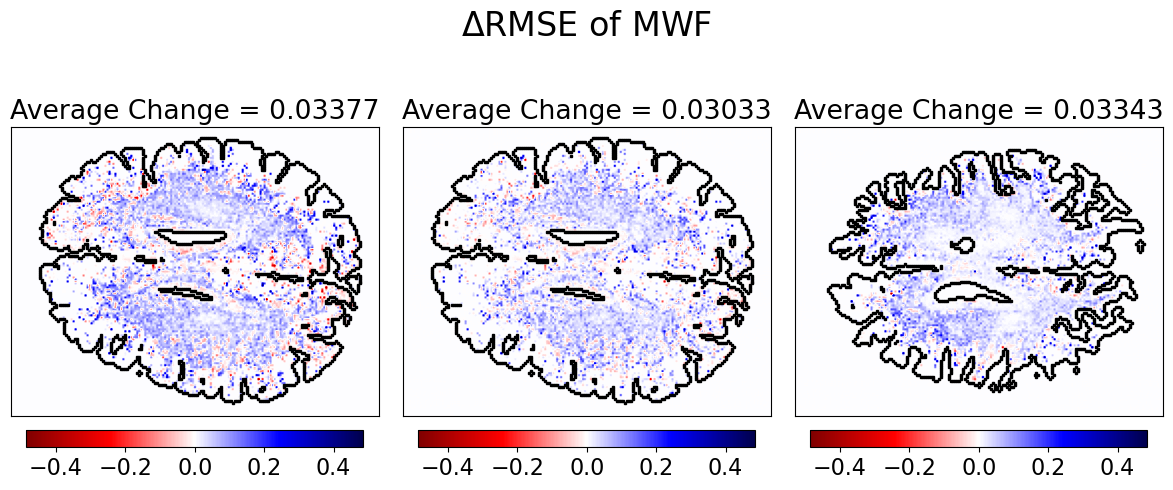

In [35]:
d1_RMSE_array = calc_RMSE(d1_p_est_mat, d1_strux_mat[1])
d1_RMSE_diff = d1_RMSE_array[2][0,:,:]**(1/2) - d1_RMSE_array[2][1,:,:]**(1/2)
d1_avgRMSE_diff = np.mean(d1_RMSE_diff[np.where(d1_RMSE_array[-1])])

d2_RMSE_array = calc_RMSE(d2_p_est_mat, d2_strux_mat[1])
d2_RMSE_diff = d2_RMSE_array[2][0,:,:]**(1/2) - d2_RMSE_array[2][1,:,:]**(1/2)
d2_avgRMSE_diff = np.mean(d2_RMSE_diff[np.where(d2_RMSE_array[-1])])

d3_RMSE_array = calc_RMSE(d3_p_est_mat, d3_strux_mat[1])
d3_RMSE_diff = d3_RMSE_array[2][0,:,:]**(1/2) - d3_RMSE_array[2][1,:,:]**(1/2)
d3_avgRMSE_diff = np.mean(d3_RMSE_diff[np.where(d3_RMSE_array[-1])])

overall_max = np.max(np.abs([d1_RMSE_diff, d2_RMSE_diff, d3_RMSE_diff]))

delta_txt = r'$\Delta$'
fig, ax = plt.subplots(1,3,figsize=(12,5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'{delta_txt}RMSE of MWF' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(d1_RMSE_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title(f'Average Change = {d1_avgRMSE_diff:0.5f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(d1_outline_indices[1],d1_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[1].imshow(d2_RMSE_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
cbar = fig.colorbar(pNLLS, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')
ax[1].set_title(f'Average Change = {d2_avgRMSE_diff:0.5f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(d2_outline_indices[1],d2_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[2].imshow(d3_RMSE_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
cbar = fig.colorbar(pNLLS, ax=ax[2], fraction=0.046, pad=0.04, location = 'bottom')
ax[2].set_title(f'Average Change = {d3_avgRMSE_diff:0.5f}')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(d3_outline_indices[1],d3_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

# plt.rc('font', size  = 14)
# fig.text(0.25, -0.05,"Nonregularized\nSuperior", ha='center')
# fig.text(0.75, -0.05,"Regularized\nSuperior", ha='center')


plt.show()

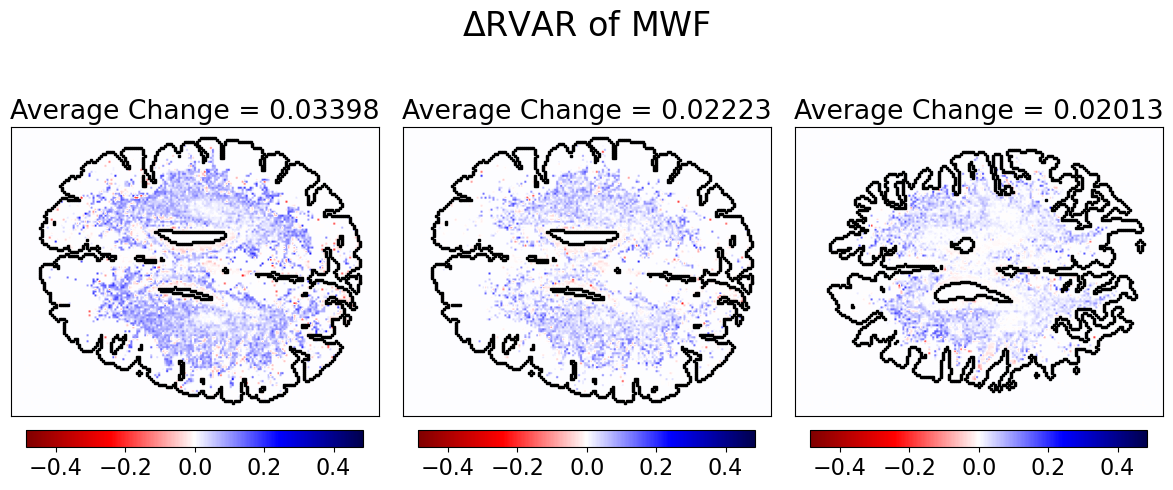

In [37]:
d1_RVAR_diff = d1_RMSE_array[1][0,:,:]**(1/2) - d1_RMSE_array[1][1,:,:]**(1/2)
d1_avgRVAR_diff = np.mean(d1_RVAR_diff[np.where(d1_RMSE_array[-1])])

d2_RVAR_diff = d2_RMSE_array[1][0,:,:]**(1/2) - d2_RMSE_array[1][1,:,:]**(1/2)
d2_avgRVAR_diff = np.mean(d2_RVAR_diff[np.where(d2_RMSE_array[-1])])

d3_RVAR_diff = d3_RMSE_array[1][0,:,:]**(1/2) - d3_RMSE_array[1][1,:,:]**(1/2)
d3_avgRVAR_diff = np.mean(d3_RVAR_diff[np.where(d3_RMSE_array[-1])])

overall_max = np.max(np.abs([d1_RMSE_diff, d2_RMSE_diff, d3_RMSE_diff]))

delta_txt = r'$\Delta$'
fig, ax = plt.subplots(1,3,figsize=(12,5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'{delta_txt}RVAR of MWF' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(d1_RVAR_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title(f'Average Change = {d1_avgRVAR_diff:0.5f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(d1_outline_indices[1],d1_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[1].imshow(d2_RVAR_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
cbar = fig.colorbar(pNLLS, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')
ax[1].set_title(f'Average Change = {d2_avgRVAR_diff:0.5f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(d2_outline_indices[1],d2_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[2].imshow(d3_RVAR_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
cbar = fig.colorbar(pNLLS, ax=ax[2], fraction=0.046, pad=0.04, location = 'bottom')
ax[2].set_title(f'Average Change = {d3_avgRVAR_diff:0.5f}')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(d3_outline_indices[1],d3_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

# plt.rc('font', size  = 14)
# fig.text(0.25, -0.05,"Nonregularized\nSuperior", ha='center')
# fig.text(0.75, -0.05,"Regularized\nSuperior", ha='center')


plt.show()

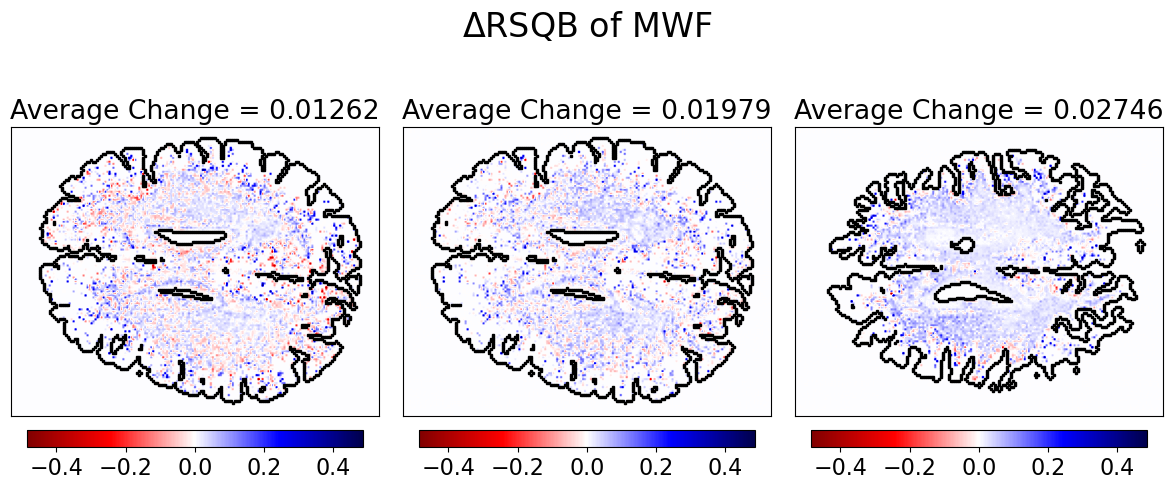

In [38]:
d1_RSQB_diff = d1_RMSE_array[0][0,:,:]**(1/2) - d1_RMSE_array[0][1,:,:]**(1/2)
d1_avgRSQB_diff = np.mean(d1_RSQB_diff[np.where(d1_RMSE_array[-1])])

d2_RSQB_diff = d2_RMSE_array[0][0,:,:]**(1/2) - d2_RMSE_array[0][1,:,:]**(1/2)
d2_avgRSQB_diff = np.mean(d2_RSQB_diff[np.where(d2_RMSE_array[-1])])

d3_RSQB_diff = d3_RMSE_array[0][0,:,:]**(1/2) - d3_RMSE_array[0][1,:,:]**(1/2)
d3_avgRSQB_diff = np.mean(d3_RSQB_diff[np.where(d3_RMSE_array[-1])])

overall_max = np.max(np.abs([d1_RMSE_diff, d2_RMSE_diff, d3_RMSE_diff]))

delta_txt = r'$\Delta$'
fig, ax = plt.subplots(1,3,figsize=(12,5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'{delta_txt}RSQB of MWF' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(d1_RSQB_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title(f'Average Change = {d1_avgRSQB_diff:0.5f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(d1_outline_indices[1],d1_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[1].imshow(d2_RSQB_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
cbar = fig.colorbar(pNLLS, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')
ax[1].set_title(f'Average Change = {d2_avgRSQB_diff:0.5f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(d2_outline_indices[1],d2_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[2].imshow(d3_RSQB_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
cbar = fig.colorbar(pNLLS, ax=ax[2], fraction=0.046, pad=0.04, location = 'bottom')
ax[2].set_title(f'Average Change = {d3_avgRSQB_diff:0.5f}')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(d3_outline_indices[1],d3_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

# plt.rc('font', size  = 14)
# fig.text(0.25, -0.05,"Nonregularized\nSuperior", ha='center')
# fig.text(0.75, -0.05,"Regularized\nSuperior", ha='center')


plt.show()